# Step 0: Introduction
#### The notebook presents a simple bare-minimum example of Deep Convolutional Generative Adverserial Network (or DCGAN). 

Note: The focus is on readability rather than functionality. None of the design choices: network, parameters, or training approach may be optimal. Making this work on larger datasets or more complicated images may require some tweaks. 

## Goal
We want to learn an image generator network _G_. It takes a vector of random numbers and spits out an image. In this specific example, we want to generate simple (28x28 pixel) images of handwritten digits.

<img src="./imgs/generator.svg" width="475">

## Why GAN?
The GAN framework allows us to learn the network G using another network which can distinguish between a real/fake image, called a disciminator network D. They work as adversaries to train each other. Hence, the name Generative Adversearial Networks.

<img src="./imgs/discriminator.svg" width="400">

## Training 
Training a GAN is different from a vanilla deep network. In each training iteration there are two steps. Step 1 updates the parameters of D using the real images and the images generated from G. And, step 2 updates the parameters of G using the feedback from the output of D. This will become more concrete using the e
<img src="./imgs/LearningGAN.svg" width="800">


In [26]:
import torch
import torch.nn.functional as F
from torch import nn
from torchvision import datasets
from torchvision import transforms
from PIL import Image
import sys

# Step 1: Load the data

In [27]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
print(mnist_trainset)

Dataset MNIST
    Number of datapoints: 60000
    Split: train
    Root Location: ./data
    Transforms (if any): ToTensor()
    Target Transforms (if any): None


Samples from MNIST dataset.
Image size: 28x28


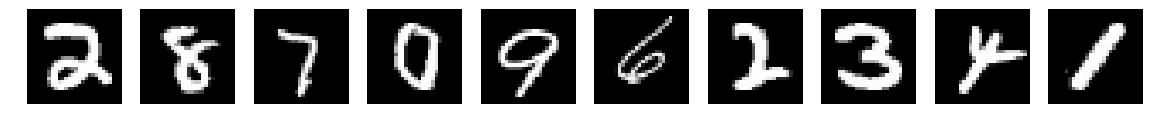

In [46]:
data_loader = torch.utils.data.DataLoader(mnist_trainset, batch_size = 10, shuffle= True)

# Get a sample batch.
it = iter(data_loader)
images, _ = it.next()

# Get an example batch.
disp_img = images.squeeze().numpy()
import numpy as np
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(20, 2))  

# Display.
print("Samples from MNIST dataset.")
print("Image size: {}x{}".format(disp_img.shape[1], disp_img.shape[2]))
for ii in range(disp_img.shape[0]):
    fig.add_subplot(1, 10, ii+1)
    plt.axis('off')
    plt.imshow(np.squeeze(disp_img[ii, :, :]), cmap='gray')


# Step 2: Define a Generator (G)

## Generator architecture
<img src="./imgs/networkG.png" width="800">



In [29]:
class Generator(nn.Module):
    def __init__(self, input_size):
        super(Generator, self).__init__()
        self.fc = nn.Linear(input_size, 4*4*128)
        self.deconv1 = nn.Sequential(nn.ConvTranspose2d(128, 64, 3, stride = 2, padding = 1),
                                     nn.BatchNorm2d(64),
                                     nn.ReLU())
        self.deconv2 = nn.Sequential(nn.ConvTranspose2d(64, 32, 4, stride = 2, padding = 1),
                                     nn.BatchNorm2d(32),
                                     nn.ReLU())
        self.deconv3 = nn.Sequential(nn.ConvTranspose2d(32, 1, 4, stride = 2, padding = 1),
                                     nn.Tanh())
                       
    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.shape[0], 128, 4, 4)
        x = self.deconv1(x)
        x = self.deconv2(x)
        x = self.deconv3(x)
        return x
    
'''
Bring the Generator output from [-1, +1] -> [0, 1]
'''
def out2img(x):
    return (x + 1.0)/2.0

'''
Preprocess the real image to input to the discriminator [-1, +1]
'''
def img2inp(x):
    return (x - 0.5)*2


## Generate a sample image


Image size: 28x28


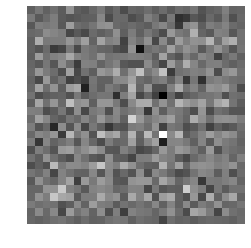

In [30]:
z_size = 100 # Size of the random input vector
G = Generator(z_size)

# Generate a random vector and pass it through the generator.
z = torch.randn(1, z_size)
g_im = G(z)

# Display.
disp_img = out2img(g_im.detach().numpy().squeeze())
print("Image size: {}x{}".format(disp_img.shape[0], disp_img.shape[1]))
plt.axis('off')
plt.imshow(disp_img, cmap='gray')
plt.show()

# Step 3: Define a Descriminator (D)

## Descriminator architecture

<img src="./imgs/networkD.png" width="900">

In [31]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(1, 32, 4, stride = 2, padding=1),
                                   nn.LeakyReLU(0.2))
        self.conv2 = nn.Sequential(nn.Conv2d(32, 64, 4, stride = 2, padding=1),
                                   nn.BatchNorm2d(64),
                                   nn.LeakyReLU(0.2))
        self.conv3 = nn.Sequential(nn.Conv2d(64, 128, 3, stride = 2, padding=1),
                                   nn.BatchNorm2d(128),
                                   nn.LeakyReLU(0.2))
        self.fc = nn.Linear(128*4*4, 1)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x


# Step 4: Training

In [32]:
# Check for CUDA
use_cuda = False
if torch.cuda.is_available(): 
    use_cuda = True
    print("Using the GPU.")
else:
    print("Cuda is not availabe, using CPU.")

Using the GPU.


## Define losses

In [42]:
def real_loss(pred):
    criterion = nn.BCEWithLogitsLoss()
    expected_output = torch.ones(pred.shape[0], 1)
    if use_cuda:
        expected_output = expected_output.cuda()
    return criterion(pred, expected_output)

def fake_loss(pred):
    criterion = nn.BCEWithLogitsLoss()
    expected_output = torch.zeros(pred.shape[0], 1)
    if use_cuda:
        expected_output = expected_output.cuda()
    return criterion(pred, expected_output)

## Training loop

In [43]:
# concatenate num_imgs x h x w tensor into a single image.
def concat_imgs(np_imgs): 
    num_imgs = np_imgs.shape[0]
    h = np_imgs.shape[1]
    w = np_imgs.shape[2]
    out = np.zeros((h, num_imgs*w))
    for i in range(num_imgs):
        out[:, i*w:(i+1)*w] = np_imgs[i,:,:]
    return out        


def train_GAN(G, D, optimizer_g, optimizer_d, input_size, batch_size = 32, num_epochs = 30):
    sample_size = 10
    z_fixed = torch.randn(sample_size, input_size)
    if use_cuda:
        z_fixed = z_fixed.cuda()
        
    # GET THE DATA
    mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
    data_loader = torch.utils.data.DataLoader(mnist_trainset, batch_size = batch_size, shuffle= True)
    
    for e in range(num_epochs):
        d_losses = 0.0
        g_losses = 0.0        
        # Iterate over the dataset.
        for ii, (real_imgs, _) in enumerate(data_loader):
            # Bring the input image pixels between -1 and 1
            real_imgs = img2inp(real_imgs)   
            if use_cuda:
                real_imgs = real_imgs.cuda()
                
            # ======== TRAIN DESCRIMNATOR ===============
            optimizer_d.zero_grad()
            
            pred = D(real_imgs)
            # D should learns to predict real image as real, i.e., label 1
            real_loss_d = real_loss(pred)
            
            # Create fake examples.
            z = torch.randn(batch_size, input_size)
            if use_cuda:
                z = z.cuda()
            fake_imgs = G(z)    
            pred = D(fake_imgs.detach())
            # D should learns to predict the generated images as fake, i.e., label 0
            fake_loss_d = fake_loss(pred) 
            
            # Descriminator opt takes a step.
            total_loss_d = real_loss_d + fake_loss_d
            total_loss_d.backward()
            optimizer_d.step()
            
            # ============= TRAIN GENERATOR =============
            optimizer_g.zero_grad()
            # Create more fake examples.
            z = torch.randn(batch_size, input_size) 
            if use_cuda:
                z = z.cuda()
            fake_imgs = G(z)
            pred = D(fake_imgs)     
            # G tries to learn such that generated images pass as real.
            loss_g = real_loss(pred) 
            loss_g.backward()
            optimizer_g.step()
            
            # Save losses
            d_losses += total_loss_d.detach().cpu().item()
            g_losses += loss_g.detach().cpu().item()
            
            sys.stdout.write("\r Processing: {}/{}...".format(ii+1, len(data_loader)))
            sys.stdout.flush()
        
        d_loss_epoch = d_losses/len(data_loader)
        g_loss_epoch = g_losses/len(data_loader)
        print("Epoch: {}, D loss: {}, G loss: {}".format(e, d_loss_epoch, g_loss_epoch))
        
        # Save a few images as example.
        G.eval()
        out_imgs = G(z_fixed)
        out_imgs = out2img(out_imgs) # Convert to right size.
        disp_imgs = np.squeeze(out_imgs.detach().cpu().numpy())
        combined_img = concat_imgs(disp_imgs)*255
        combined_img = combined_img.astype(np.uint8)
        img_to_save = Image.fromarray(combined_img)
        img_to_save.save("./data/sample_output{}.png".format(e))
        
        # Save the checkpoint
        checkpoint = {
            'epoch': e + 1,
            'state_dict': G.state_dict()         
        }
        torch.save(checkpoint, 'checkpoint.pth')
        G.train()
    print("Done training!")

# Start training!

In [44]:
import os

G = Generator(z_size)
D = Discriminator()
if use_cuda:
    G = G.cuda()
    D = D.cuda()

if os.path.exists('checkpoint.pth'):
    print("Loading trained model from file...")
    G.load_state_dict(torch.load('checkpoint.pth')["state_dict"])
else:
    print("Training...")
    # Train your own model.
    lr = 0.0001
    beta1 = 0.5
    beta2 = 0.999

    optimg = torch.optim.Adam(G.parameters(), lr=lr, betas=(beta1, beta2))
    optimd = torch.optim.Adam(D.parameters(), lr=lr, betas=(beta1, beta2))
    train_GAN(G, D, optimg, optimd, z_size)

Loading trained model from file...


## Training progress

#### Sample image:  epoch 01
<img src="./imgs/sample_output0.png" width="800">

#### Sample images: epoch 30
<img src="./imgs/sample_output29.png" width="800">

# Step 4: Generate new images

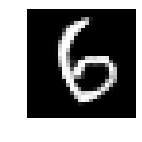

In [58]:
G.eval()
z = torch.randn(1, z_size)
if use_cuda:
    z = z.cuda()
G_out = G(z)
img = np.squeeze(G_out.detach().cpu().numpy())

plt.figure(figsize=(2, 2))  
plt.axis('off')
plt.imshow(img, cmap='gray')
plt.show()

# References
1. Wonderful animations of convolution arithmatic: https://github.com/vdumoulin/conv_arithmetic
2. A more detailed GAN example from torch developes: https://github.com/pytorch/examples/tree/master/dcgan
3. How to train a GAN: tips and tricks: https://github.com/soumith/ganhacks